Homework 11
Fit an autoencoder to the chest xray medical mnist dataset. Do the following

Evaluate and compare the training and testing erorr of the autoencoder.
Show the result of feeding a few training and testing images through the autoencoder.
You should submit a single ipynb with your results.

You can install the medical mnist data with the command below. Followin is a set of commands to download the data and load it into a pytorch dataset.

In [71]:
from tqdm import tqdm
import PIL
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

import torch.utils.data as data

import medmnist
from medmnist.dataset import PathMNIST, ChestMNIST, DermaMNIST, OCTMNIST, PneumoniaMNIST, RetinaMNIST, BreastMNIST, OrganMNISTAxial, OrganMNISTCoronal, OrganMNISTSagittal
from medmnist.evaluator import getAUC, getACC
from medmnist.info import INFO

In [126]:
data_flag = 'chestmnist'
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])


transform =   transforms.ToTensor()
n_epochs = 10
lr = 0.001
data.transform =transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize( mean=[.5], std=[.5] )
])

train_dataset = DataClass(split='train', transform=transform, download = True)
test_dataset = DataClass(split='test',transform=transform, download = True)
nonormorm =  DataClass(split='train', transform=transforms.ToTensor(), download=True)

Using downloaded and verified file: /home/jupyter-tliu76/.medmnist/chestmnist.npz
Using downloaded and verified file: /home/jupyter-tliu76/.medmnist/chestmnist.npz
Using downloaded and verified file: /home/jupyter-tliu76/.medmnist/chestmnist.npz


In [127]:
print(train_dataset)
print("===================")
print(test_dataset)
print("===================")
print(nonorm_dataset)

Dataset ChestMNIST (chestmnist)
    Number of datapoints: 78468
    Root location: /home/jupyter-tliu76/.medmnist
    Split: train
    Task: multi-label, binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'atelectasis', '1': 'cardiomegaly', '2': 'effusion', '3': 'infiltration', '4': 'mass', '5': 'nodule', '6': 'pneumonia', '7': 'pneumothorax', '8': 'consolidation', '9': 'edema', '10': 'emphysema', '11': 'fibrosis', '12': 'pleural', '13': 'hernia'}
    Number of samples: {'train': 78468, 'val': 11219, 'test': 22433}
    Description: The ChestMNIST is based on the NIH-ChestXray14 dataset, a dataset comprising 112,120 frontal-view X-Ray images of 30,805 unique patients with the text-mined 14 disease labels, which could be formulized as a multi-label binary-class classification task. We use the official data split, and resize the source images of 1×1024×1024 into 1×28×28.
    License: CC BY 4.0
Dataset ChestMNIST (chestmnist)
    Number of datapoints: 22433
    Root locati

In [74]:
## Load it into a train and test loader

train_loader = data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

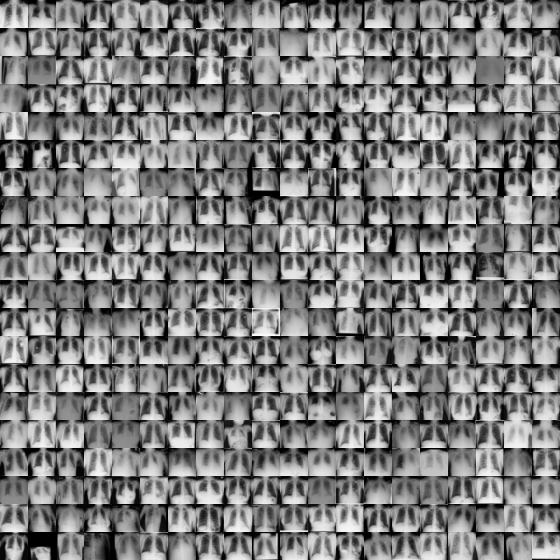

In [131]:
## Visualize the data
train_dataset.montage(length=20)

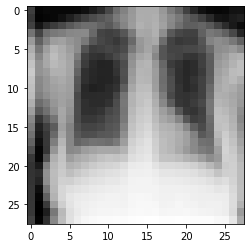

In [132]:
# visualization

img, target = nonorm_dataset[0]
if n_channels == 1:
    img = img.reshape(28, 28)
    plt.imshow(img, cmap='gray')
else:
    img = img.permute(1, 2, 0)
    plt.imshow(img)

In [205]:
kernel_size = 8
class autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 4, kernel_size)
        self.conv2 = nn.Conv2d(4, 12, kernel_size)
        self.pool  = nn.MaxPool2d(2, 2)
        self.iconv1 = nn.ConvTranspose2d(12, 4, kernel_size+2, stride = 2)
        self.iconv2 = nn.ConvTranspose2d(4, 1, kernel_size+2, stride = 2)

    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        return x
    
    def decode(self, x):
        x = F.relu(self.iconv1(x))
        ## Use the sigmoid as the final layer 
        ## since we've normalized pixel values to be between 0 and 1
        x = torch.sigmoid(self.iconv2(x))
        return(x)
    
    def forward(self, x):
        return self.decode(self.encode(x))

autoencoder = autoencoder()
    

In [206]:
## Here's some example data by grabbing one batch
tryItOut,label = iter(train_loader).next()
print(tryItOut.shape)

## Let's encode that data
encoded = autoencoder.encode(tryItOut)
print(encoded.shape)

## Now let's decode the encoded data
decoded = autoencoder.decode(encoded)
print(decoded.shape)

## Now let's run the whole thing through
fedForward = autoencoder.forward(tryItOut)
print(fedForward.shape)


torch.Size([100, 1, 28, 28])
torch.Size([100, 12, 1, 1])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])


In [207]:
## Here's some example data by grabbing one batch
tryItOut,label = iter(train_loader).next()
print(tryItOut.shape)

## Let's encode that data
encoded = autoencoder.encode(tryItOut)
print(encoded.shape)

## Now let's decode the encoded data
decoded = autoencoder.decode(encoded)
print(decoded.shape)

## Now let's run the whole thing through
fedForward = autoencoder.forward(tryItOut)
print(fedForward.shape)

torch.Size([100, 1, 28, 28])
torch.Size([100, 12, 1, 1])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])


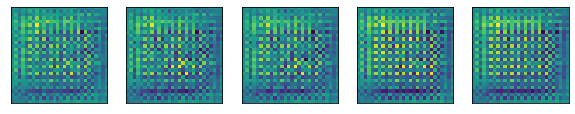

In [208]:
test = fedForward.detach().numpy()

## Plot out the first 5 images, note this isn't very interesting, since
## all of the weights haven't been trained
plt.figure(figsize=(10,5))
for i in range(5): 
  plt.subplot(1, 5,i+1)
  plt.xticks([])
  plt.yticks([])
  img = np.transpose(test[i,:,:,:], (1, 2, 0))
  plt.imshow(img)

In [209]:
#Optimizer
optimizer = torch.optim.Adam(autoencoder.parameters(), lr = 0.001)

#Epochs
n_epochs = 20

autoencoder.train()


autoencoder(
  (conv1): Conv2d(1, 4, kernel_size=(8, 8), stride=(1, 1))
  (conv2): Conv2d(4, 12, kernel_size=(8, 8), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (iconv1): ConvTranspose2d(12, 4, kernel_size=(10, 10), stride=(2, 2))
  (iconv2): ConvTranspose2d(4, 1, kernel_size=(10, 10), stride=(2, 2))
)

In [210]:
for epoch in range(n_epochs):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    for inputs, targets in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = autoencoder.forward(inputs)
        loss = F.mse_loss(outputs, targets)
        loss.backward()
        optimizer.step()

  0%|          | 0/785 [00:00<?, ?it/s]/tmp/ipykernel_1943193/791027544.py:9: UserWarning: Using a target size (torch.Size([100, 14])) that is different to the input size (torch.Size([100, 1, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(outputs, targets)
  0%|          | 0/785 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (28) must match the size of tensor b (14) at non-singleton dimension 3

In [96]:
for epoch in range(n_epochs):
    for inputs, targets in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = autoencoder.forward(inputs)
        loss = F.mse_loss(outputs, targets)
        loss.backward()
        optimizer.step()
        
        
        # train
for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

  0%|          | 0/785 [00:00<?, ?it/s]


NameError: name 'criterion' is not defined

In [ ]:
# train
for epoch in range(n_epochs):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

In [ ]:
## the data from the last iteration is called images
trainSample = images.detach().numpy()

plt.figure(figsize=(10,5))
for i in range(5): 
  plt.subplot(1, 5,i+1)
  plt.xticks([])
  plt.yticks([])
  img = np.transpose(trainSample[i,:,:,:], (1, 2, 0))
  plt.imshow(img)

## the output from the last iterations (feed forward through the network) is called outputs
trainOutput = outputs.detach().numpy()

plt.figure(figsize=(10,5))
for i in range(5): 
  plt.subplot(2, 5,i+6)
  plt.xticks([])
  plt.yticks([])
  img = np.transpose(trainOutput[i,:,:,:], (1, 2, 0))
  plt.imshow(img)

In [65]:
import os

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

kernel_size = 5
class autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 6, kernel_size)
        self.conv2 = nn.Conv2d(6, 12, kernel_size)
        self.pool  = nn.MaxPool2d(2, 2)
        self.iconv1 = nn.ConvTranspose2d(12, 6, kernel_size+1, stride = 2)
        self.iconv2 = nn.ConvTranspose2d(6, 3, kernel_size+1, stride = 2)

    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        return x
    
    def decode(self, x):
        x = F.relu(self.iconv1(x))
        ## Use the sigmoid as the final layer 
        ## since we've normalized pixel values to be between 0 and 1
        x = torch.sigmoid(self.iconv2(x))
        return(x)
    
    def forward(self, x):
        return self.decode(self.encode(x))
    
autoencoder = autoencoder()

(2,)

In [56]:
data_transform = transforms.Compose([
    transforms.ToTensor()#,
    #transforms.Normalize(mean=[.5], std=[.5])
])


In [59]:
train_loader = data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True, num_workers = 4, pin_memory = True)


In [60]:
for data in train_loader:
     img, label = data

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/tljh/user/lib/python3.9/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/tljh/user/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    return self.collate_fn(data)
  File "/opt/tljh/user/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py", line 84, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/opt/tljh/user/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py", line 84, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/opt/tljh/user/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py", line 86, in default_collate
    raise TypeError(default_collate_err_msg_format.format(elem_type))
TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>


In [61]:
tryItOut,label=iter(train_loader).next()

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/tljh/user/lib/python3.9/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/tljh/user/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    return self.collate_fn(data)
  File "/opt/tljh/user/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py", line 84, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/opt/tljh/user/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py", line 84, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/opt/tljh/user/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py", line 86, in default_collate
    raise TypeError(default_collate_err_msg_format.format(elem_type))
TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>


In [50]:
## Here's some example data by grabbing one batch
tryItOut = iter(train_loader).next()
print(tryItOut.shape)

## Let's encode that data
encoded = autoencoder.encode(tryItOut)
print(encoded.shape)

## Now let's decode the encoded data
decoded = autoencoder.decode(encoded)
print(decoded.shape)

## Now let's run the whole thing through
fedForward = autoencoder.forward(tryItOut)
print(fedForward.shape)

AttributeError: 'list' object has no attribute 'shape'

In [17]:
test = fedForward.detach().numpy()

## Plot out the first 5 images, note this isn't very interesting, since
## all of the weights haven't been trained
plt.figure(figsize=(10,5))
for i in range(5): 
  plt.subplot(1, 5,i+1)
  plt.xticks([])
  plt.yticks([])
  img = np.transpose(test[i,:,:,:], (1, 2, 0))
  plt.imshow(img)

NameError: name 'fedForward' is not defined

In [18]:
#Optimizer
optimizer = torch.optim.Adam(autoencoder.parameters(), lr = 0.001)

#Epochs
n_epochs = 20

autoencoder.train()


for epoch in range(n_epochs):
    for data in trainLoader:
        images = data
        optimizer.zero_grad()
        outputs = autoencoder.forward(images)
        loss = F.mse_loss(outputs, images)
        loss.backward()
        optimizer.step()
          

NameError: name 'trainLoader' is not defined

In [19]:
## the data from the last iteration is called images
trainSample = images.detach().numpy()

plt.figure(figsize=(10,5))
for i in range(5): 
  plt.subplot(1, 5,i+1)
  plt.xticks([])
  plt.yticks([])
  img = np.transpose(trainSample[i,:,:,:], (1, 2, 0))
  plt.imshow(img)

## the output from the last iterations (feed forward through the network) is called outputs
trainOutput = outputs.detach().numpy()

plt.figure(figsize=(10,5))
for i in range(5): 
  plt.subplot(2, 5,i+6)
  plt.xticks([])
  plt.yticks([])
  img = np.transpose(trainOutput[i,:,:,:], (1, 2, 0))
  plt.imshow(img)

NameError: name 'images' is not defined

In [20]:
testLoader  = torch.utils.data.DataLoader(torch.Tensor(x_test), batch_size = 100, shuffle = False, num_workers = 1)
testSample = autoencoder.forward(iter(testLoader).next()).detach().numpy()

NameError: name 'x_test' is not defined

NameError: name 'x_test' is not defined

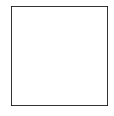

In [21]:
plt.figure(figsize=(10,4))

## Plot the original data
for i in range(5): 
  plt.subplot(2, 5, i + 1)
  plt.xticks([])
  plt.yticks([])
  img = np.transpose(x_test[i,:,:,:], (1, 2, 0))
  plt.imshow(img)
# Plot the data having been run throught the convolutional autoencoder
for i in range(5): 
  plt.subplot(2, 5, i + 6)
  plt.xticks([])
  plt.yticks([])
  img = np.transpose(testSample[i,:,:,:], (1, 2, 0))
  plt.imshow(img)